# 4. Searching for similar weather patterns

## 4.1 Introduction
We are now going to use the compressed dataset to search for similar weather patterns. This is done by calculating the Euclidian distance between the reference date and all the other dates. Dates with the smallest distance will be those with the most similar weather. As this operation is computational intensive when the dimensions are big, this operation will be done on the compressed dataset. At the end of this notebook, we will check the correlation between the distance in compressed and uncompressed (MSL/Z500) space.

We will start with the initializations for this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from isoplot import isoplot
import pandas as pd

# load data
era20c = np.load("data/era20c.npy")
compressed = np.load("data/era20c_compressed.npy")
dates = np.load("data/dates.npy")
scale = np.load("data/scale.npy")
zone = np.load("data/zone.npy")
msl = np.load("data/msl.npy")
z500 = np.load("data/z500.npy")

# reshaping 2 spatial dimensions to 1, to be able to use the numpy norm
shape1 = era20c.shape[1] 
shape2 = era20c.shape[2]
grid_points = shape1 * shape2
grid_sqrt = np.sqrt(grid_points) 
era20c = era20c.reshape(era20c.shape[0],grid_points,era20c.shape[3])
compressed = compressed.reshape(compressed.shape[0],compressed.shape[1]*compressed.shape[2]*compressed.shape[3])

## 4.2 Spread of dataset
As the goal is to calculate distances between similar synoptic situations, we want to know the spread of the dataset as a reference (in N-dimensional space, N is the number of grid points). 
We would like to have monthly statistics, for this we will use the timeseries functionality of Pandas. The spread is defined here as the N-dimensional standard deviation, divided by the square root of the number of grid points.

In [2]:
pd.options.display.float_format = '{:.0f}'.format
pd_msl = pd.DataFrame(msl.reshape(msl.shape[0],msl.shape[1]*msl.shape[2]))
pd_z500 = pd.DataFrame(z500.reshape(z500.shape[0],z500.shape[1]*z500.shape[2]))
pd_msl["date"] = dates
pd_z500["date"] = dates 
pd_msl["date"] = pd.to_datetime(pd_msl["date"])
pd_z500["date"] = pd.to_datetime(pd_z500["date"])
pd_msl = pd_msl.set_index("date")
pd_z500 = pd_z500.set_index("date")
stat = pd_msl.groupby(pd_msl.index.month).var().sum(axis=1).to_frame() ** (0.5) / grid_sqrt
stat.columns = ["MSL Spread [Pa]"]
stat["Z500 Spread [m**2/s**2]"] = pd_z500.groupby(pd_z500.index.month).var().sum(axis=1).to_frame() ** (0.5) / grid_sqrt
stat

,MSL Spread [Pa],Z500 Spread [m**2/s**2]
date,,
1,1219,1323
2,1207,1324
3,1088,1229
4,902,1082
5,741,946
6,635,815
7,558,679
8,583,699
9,747,899


## 4.3 Search similar weather patterns
In the cell below a date can be set for searching similar patterns. The dates with the smallest difference in compressed space are listed in the table. The output also shows the distance in uncompressed MSL/Z500 space (scaled towards the [0,1] interval), as well as the distance (divided by the square root of the number of grid points) in MSL (in Pa) and Z500 (in m<sup>2</sup>/s<sup>2</sup>) space.

In [3]:
# set the reference date here
date = "1990 1 25"
#date = "1953 1 31"
#date = "1976 1 2"
#date = "1976 8 1"
#date = "2003 8 10"

# corresponding reference data
date_index = np.where(dates == date)
compressed_ref = compressed[date_index]
era20c_ref = era20c[date_index]
msl_ref = msl[date_index]
z500_ref = z500[date_index]

# initialize arrays
compressed_dist = np.zeros(dates.shape[0])
msl_dist = np.zeros(dates.shape[0])
z500_dist = np.zeros(dates.shape[0])
era20c_dist = np.zeros(dates.shape[0])

# calculate distances
for i in range(dates.shape[0]):
    compressed_dist[i] = np.linalg.norm(compressed[i]-compressed_ref)
    era20c_dist[i] = np.linalg.norm(era20c[i]-era20c_ref)
    msl_dist[i] = np.linalg.norm(msl[i]-msl_ref) / grid_sqrt
    z500_dist[i] = np.linalg.norm(z500[i]-z500_ref) / grid_sqrt

# smallest distances
smallest_compressed = np.argsort(compressed_dist)[:25]
print("Index\tDate\t\tCompr.Dist.\tUncompr.Dist.\tMSL Dist.[Pa]\tZ500 Dist.[m**2/s**2]")
for i in smallest_compressed:
    print("%d\t%s\t%.3f\t\t%.3f\t\t%.0f\t\t%.0f" % (i,dates[i],compressed_dist[i],era20c_dist[i],msl_dist[i],z500_dist[i]))

Index	Date		Compr.Dist.	Uncompr.Dist.	MSL Dist.[Pa]	Z500 Dist.[m**2/s**2]
32896	1990 1 25	0.000		0.000		0		0
23757	1965 1 17	0.297		3.086		715		604
32180	1988 2 9	0.310		3.664		852		713
30693	1984 1 14	0.310		3.731		771		859
31493	1986 3 24	0.322		3.340		691		768
32142	1988 1 2	0.326		3.450		802		672
36174	1999 1 16	0.344		3.807		799		862
32913	1990 2 11	0.366		3.791		796		857
36154	1998 12 27	0.366		3.307		732		699
8086	1922 2 21	0.368		3.985		1015		610
32897	1990 1 26	0.371		3.571		851		661
31432	1986 1 22	0.373		3.826		778		895
33239	1991 1 3	0.390		3.445		738		760
33241	1991 1 5	0.402		4.024		853		901
10967	1930 1 11	0.411		4.126		851		952
17896	1948 12 31	0.417		4.299		857		1026
22252	1960 12 4	0.418		3.930		814		902
31496	1986 3 27	0.419		4.368		1014		853
36173	1999 1 15	0.421		4.367		953		942
30302	1982 12 19	0.424		4.605		1048		931
39056	2006 12 7	0.430		4.181		806		1028
33939	1992 12 3	0.430		4.093		905		866
18249	1949 12 19	0.435		4.905		1153		934
20801	1956 12 14	0.437		4.05

## 4.4 Plotting similar weather patterns
We will plot the MSL/Z500 from the reference date together with the synoptic similar situation. The nearby parameter can be changed to 2 (or 3) to plot the second (or third) nearest pattern.

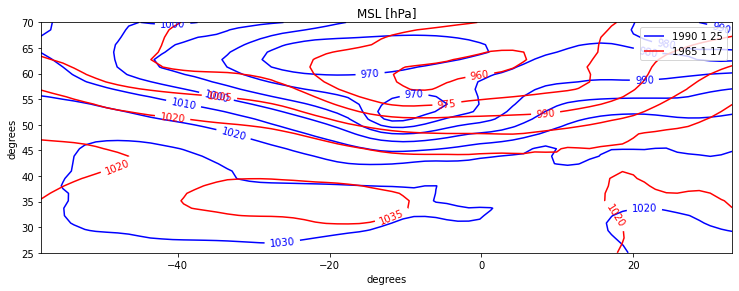

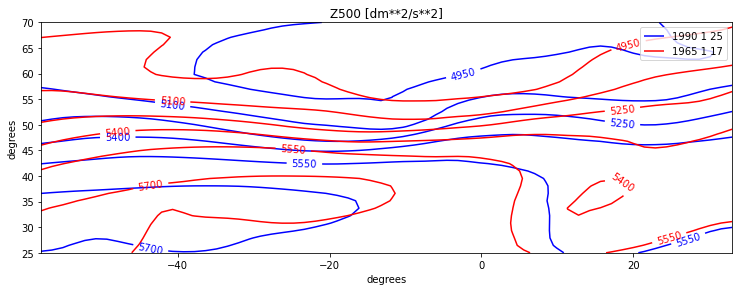

In [4]:
# for 2nd smallest: set nearby to 2
nearby = 1
min_dist_index = smallest_compressed[nearby]  
original = era20c[date_index].reshape(1,shape1,shape2,2)
nearest = era20c[min_dist_index].reshape(1,shape1,shape2,2)
isoplot(original[0,:,:,0],nearest[0,:,:,0],date,dates[min_dist_index],zone,scale[0])
isoplot(original[0,:,:,1],nearest[0,:,:,1],date,dates[min_dist_index],zone,scale[1]*10,"Z500 [dm**2/s**2]")

## 4.5 Distance in compressed and uncompressed space
The scatter plots below show:
- distances in compressed versus uncompressed (scaled combined MSL/Z500) space
- compressed distances versus MSL distances (divided by the square root of the number of grid points) [Pa] 
- compressed distances versus Z500 distances (divided by the square root of the number of grid points) [m<sup>2</sup>/s<sup>2</sup>]

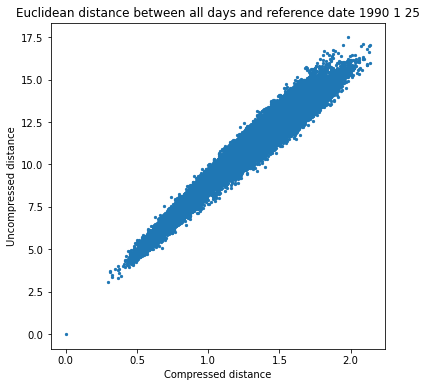

Pearson correlation coefficient: 0.972


In [5]:
plt.rcParams["figure.figsize"] = (6,6)
plt.scatter(compressed_dist, era20c_dist, s=5)
plt.ylabel("Uncompressed distance")
plt.xlabel("Compressed distance")
plt.title("Euclidean distance between all days and reference date " + date)
plt.show()
print("Pearson correlation coefficient: %.3f" % np.corrcoef(compressed_dist,era20c_dist)[0,1])

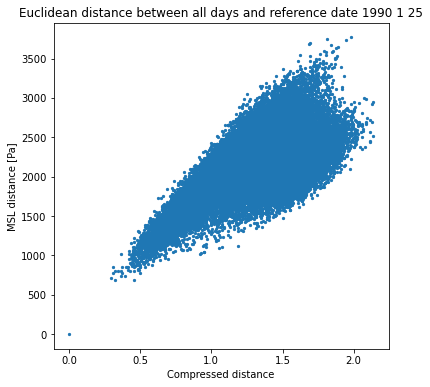

Pearson correlation coefficient: 0.637


In [6]:
plt.rcParams["figure.figsize"] = (6,6)
plt.scatter(compressed_dist, msl_dist, s=5)
plt.ylabel("MSL distance [Pa]")
plt.xlabel("Compressed distance")
plt.title("Euclidean distance between all days and reference date " + date)
plt.show()
print("Pearson correlation coefficient: %.3f" % np.corrcoef(compressed_dist,msl_dist)[0,1])

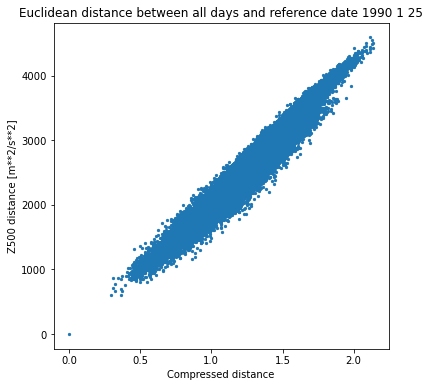

Pearson correlation coefficient: 0.979


In [7]:
plt.rcParams["figure.figsize"] = (6,6)
plt.scatter(compressed_dist, z500_dist, s=5) 
plt.ylabel("Z500 distance [m**2/s**2]")
plt.xlabel("Compressed distance")
plt.title("Euclidean distance between all days and reference date " + date)
plt.show()
print("Pearson correlation coefficient: %.3f" % np.corrcoef(compressed_dist,z500_dist)[0,1])

## 4.6 Mean Correlation between distances
The correlation coefficients calculated so far are referring towards one reference date. We would like to have a mean correlation for all dates. To keep the computation time under control, we will take a sample of 100 random days (out the complete 40542 days).

In [8]:
sample_size = 100
rand_indices = np.random.randint(era20c.shape[0],size=sample_size)
corr =  np.zeros(sample_size)
corr_msl =  np.zeros(sample_size)
corr_z500 =  np.zeros(sample_size)
for i in range(sample_size):
    date_index = rand_indices[i]
    compressed_ref = compressed[date_index]
    era20c_ref = era20c[date_index]
    msl_ref = msl[date_index]
    z500_ref = z500[date_index]

    # initialize arrays
    compressed_dist = np.zeros(dates.shape[0])
    msl_dist = np.zeros(dates.shape[0])
    z500_dist = np.zeros(dates.shape[0])
    era20c_dist = np.zeros(dates.shape[0])

    # calculate distances
    for j in range(dates.shape[0]):
        compressed_dist[j] = np.linalg.norm(compressed[j]-compressed_ref)
        era20c_dist[j] = np.linalg.norm(era20c[j]-era20c_ref)
        msl_dist[j] = np.linalg.norm(msl[j]-msl_ref) / grid_sqrt
        z500_dist[j] = np.linalg.norm(z500[j]-z500_ref) / grid_sqrt
        
    # calculate correlation coefficients
    corr[i] = np.corrcoef(compressed_dist,era20c_dist)[0,1]
    corr_msl[i] = np.corrcoef(compressed_dist,msl_dist)[0,1]
    corr_z500[i] = np.corrcoef(compressed_dist,z500_dist)[0,1]

In [9]:
pd.options.display.float_format = '{:.3f}'.format
pd_corr = pd.DataFrame(corr, columns=['corr'])
pd_corr['corr_msl'] = pd.DataFrame(corr_msl, columns=['corr'])
pd_corr['corr_z500'] = pd.DataFrame(corr_z500, columns=['corr'])
pd_corr.describe()

,corr,corr_msl,corr_z500
count,100.000,100.000,100.000
mean,0.927,0.538,0.963
std,0.061,0.308,0.025
min,0.748,-0.214,0.898
25%,0.893,0.305,0.947
50%,0.949,0.679,0.972
75%,0.978,0.808,0.985
max,0.989,0.875,0.991


The mean correlation of the distances between uncompressed and compressed space is 0.927 with standard error of 0.006. The mean correlation is the highest between compressed and Z500 space (0.963 m<sup>2</sup>/s<sup>2</sup> with standard error of 0.002 m<sup>2</sup>/s<sup>2</sup>). The correlation between compressed and MSL is significant lower (0.538 Pa with standard error of 0.031 Pa). Most probably this is related to the fact that Z500 isohypses have a less erratic behavior (less high frequencies) than the MSL isobars.


In [10]:
pd_corr.std()/np.sqrt(sample_size) 

corr        0.006
corr_msl    0.031
corr_z500   0.002
dtype: float64